In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Đọc dữ liệu
data = pd.read_csv('../datas/data_total_nam.csv')

In [69]:
import sys
sys.path.append('../extraction')  

from extraction import (
    create_training_data,
    calculate_accelerometer_features,
    calculate_accelerometer_fft_features,
    create_training_data_NN_like_micro
)

x_list, y_list, z_list, train_labels = create_training_data(
    data=data, window_size=10, step_size=5)


In [70]:
print("📌 Các nhãn xuất hiện:", set(train_labels))


📌 Các nhãn xuất hiện: {np.int64(0), np.int64(1)}


In [71]:
features = calculate_accelerometer_features(
    x_list=x_list, y_list=y_list, z_list=z_list, window_size=10)
# test

# Kiểm tra có bao nhiêu giá trị NaN
print("🔍 Số NaN trong mỗi cột:")
print(features.isna().sum().sort_values(ascending=False).head(10))

features = features.fillna(features.mean())

c:\Users\ADMIN\OneDrive\Máy tính\Master_2024\new_sleep_posture_2025\nam_hay_k_nam\../extraction\extraction.py:102: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  X_train['x_skewness'] = [stats.skew(x) for x in x_list]
c:\Users\ADMIN\OneDrive\Máy tính\Master_2024\new_sleep_posture_2025\nam_hay_k_nam\../extraction\extraction.py:103: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  X_train['y_skewness'] = [stats.skew(y) for y in y_list]
c:\Users\ADMIN\OneDrive\Máy tính\Master_2024\new_sleep_posture_2025\nam_hay_k_nam\../extraction\extraction.py:104: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  X_train['z_skewness'] = 

🔍 Số NaN trong mỗi cột:
x_skewness    243
x_kurtosis    243
y_kurtosis     66
y_skewness     66
z_skewness     34
z_kurtosis     34
z_mean          0
x_std           0
z_aad           0
x_min           0
dtype: int64


In [72]:
from sklearn.model_selection import train_test_split

(
    features_train, features_test,
    label_train, label_test
) = train_test_split(
    features, train_labels,
    test_size=0.25,
    random_state=42,
    shuffle=True
)


 Training Random Forest (optimized)...

 Random Forest Evaluation Results
 Training Accuracy: 1.0000
 Validation Accuracy: 1.0000
 Test Accuracy: 1.0000

--- Validation Report ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       259
           1       1.00      1.00      1.00       335

    accuracy                           1.00       594
   macro avg       1.00      1.00      1.00       594
weighted avg       1.00      1.00      1.00       594


--- Test Report ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       402
           1       1.00      1.00      1.00       588

    accuracy                           1.00       990
   macro avg       1.00      1.00      1.00       990
weighted avg       1.00      1.00      1.00       990



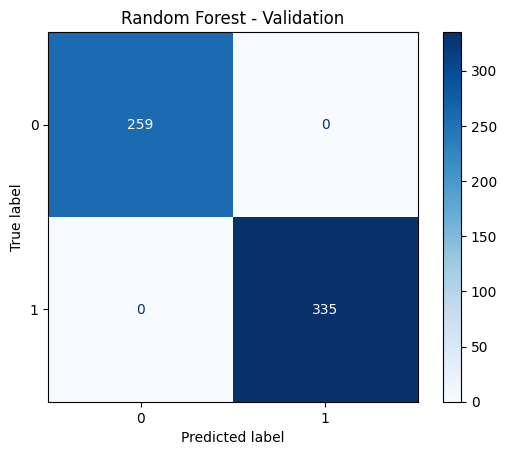

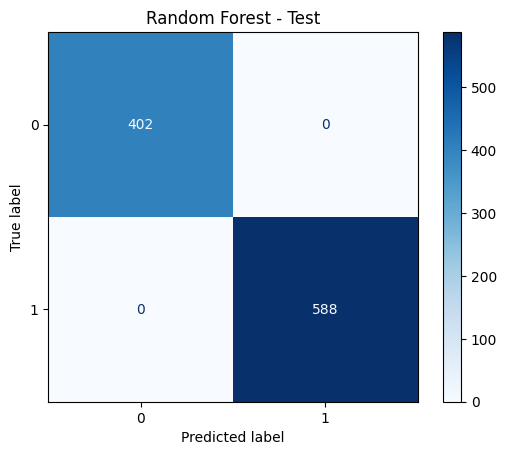

In [73]:

from models import train_RF
modelRF = train_RF(features_train, features_test, label_train, label_test)


PermutationExplainer explainer: 2969it [02:34, 18.00it/s]                          


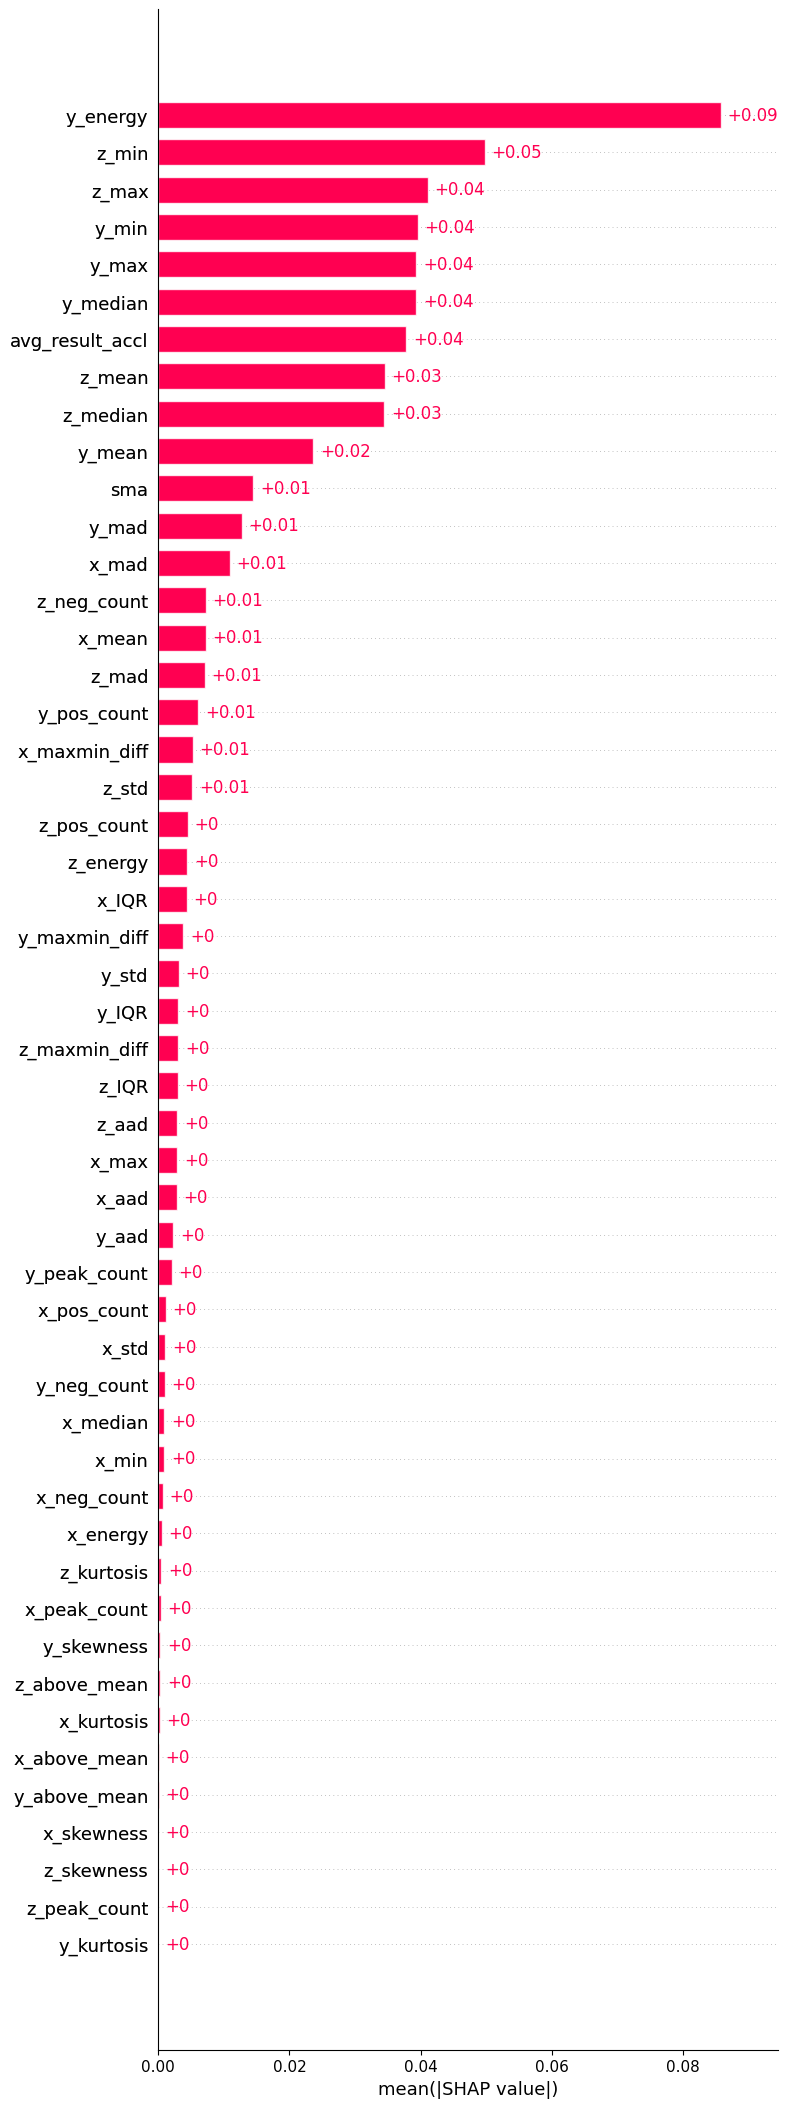

In [74]:
import shap

explainer = shap.Explainer(modelRF.predict, features_train)
shap_values = explainer(features_train)
shap.plots.bar(shap_values, max_display=50)

 Training Logistic Regression (optimized)...

 Logistic Regression Evaluation Results
 Training Accuracy: 1.0000
 Validation Accuracy: 1.0000
 Test Accuracy: 1.0000

--- Validation Report ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       259
           1       1.00      1.00      1.00       335

    accuracy                           1.00       594
   macro avg       1.00      1.00      1.00       594
weighted avg       1.00      1.00      1.00       594


--- Test Report ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       402
           1       1.00      1.00      1.00       588

    accuracy                           1.00       990
   macro avg       1.00      1.00      1.00       990
weighted avg       1.00      1.00      1.00       990



C:\Users\ADMIN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


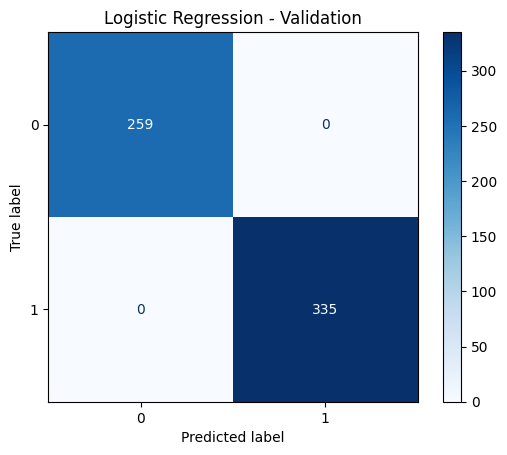

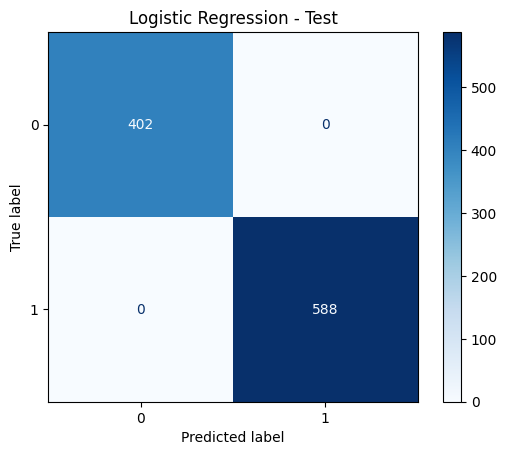

In [75]:
from models import train_LR
modelLR, scalerLr = train_LR(features_train, features_test, label_train, label_test)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_11076\1594260206.py:17: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_scaled, plot_type="bar", max_display=50)


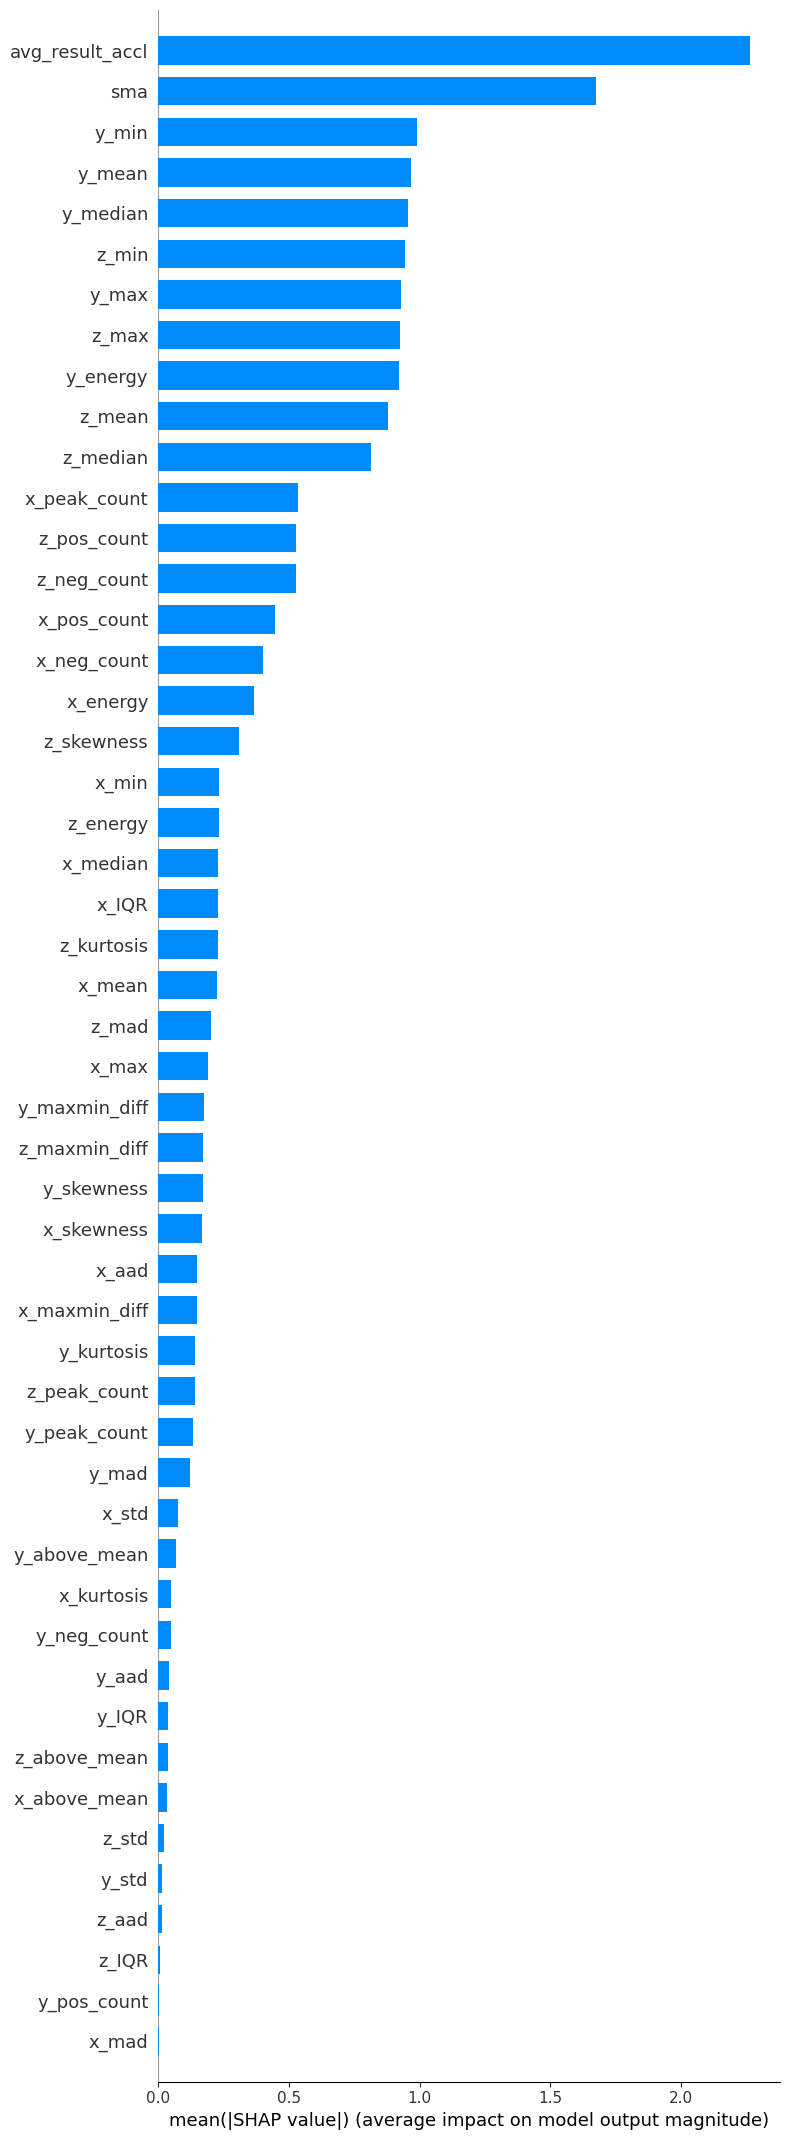

In [76]:
import shap
import pandas as pd

# ⚙️ Bước 1: Đảm bảo features_all là DataFrame có tên cột
# (bạn đã làm đúng ở trên với features và features_fft)
# ⚠️ Tuy nhiên sau khi chuẩn hóa, cần gắn lại tên cột:
X_scaled = scalerLr.transform(features_train)
X_scaled = pd.DataFrame(X_scaled, columns=features_train.columns)

# ⚙️ Bước 2: Tạo LinearExplainer
explainer = shap.LinearExplainer(modelLR, X_scaled, feature_names=features_train.columns)

# ⚙️ Bước 3: Tính SHAP values
shap_values = explainer.shap_values(X_scaled)

# ⚙️ Bước 4: Vẽ biểu đồ SHAP
shap.summary_plot(shap_values, X_scaled, plot_type="bar", max_display=50)

💡 Training SVM (optimized)...

 Support Vector Machine Evaluation Results
 Training Accuracy: 1.0000
 Validation Accuracy: 1.0000
 Test Accuracy: 1.0000

--- Validation Report ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       259
           1       1.00      1.00      1.00       335

    accuracy                           1.00       594
   macro avg       1.00      1.00      1.00       594
weighted avg       1.00      1.00      1.00       594


--- Test Report ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       402
           1       1.00      1.00      1.00       588

    accuracy                           1.00       990
   macro avg       1.00      1.00      1.00       990
weighted avg       1.00      1.00      1.00       990



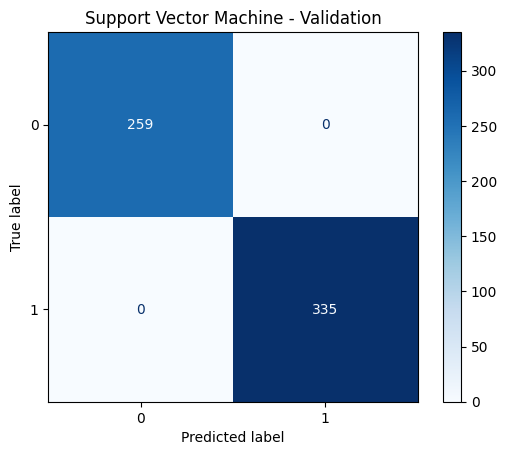

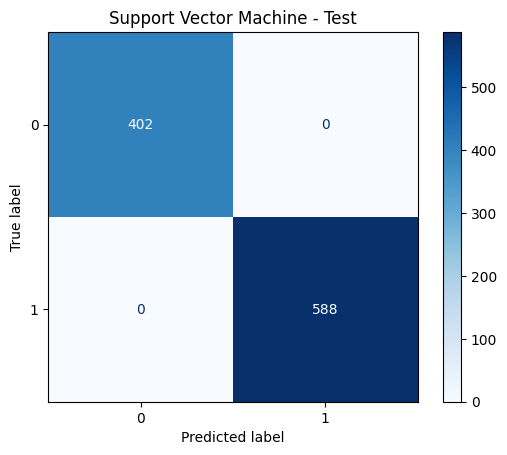

In [77]:
from models import train_SVM
modelSVM, scalerSVM = train_SVM(features_train, features_test, label_train, label_test)

In [78]:
import shap
import numpy as np
import pandas as pd
X_train_scaled = scalerSVM.transform(features_train)
X_test_scaled = scalerSVM.transform(features_test)
explainer = shap.KernelExplainer(modelSVM.predict, X_train_scaled[:200])  # dùng 200 mẫu đầu làm background (để tiết kiệm thời gian)

# ⚙️ Tính giá trị SHAP
shap_values = explainer.shap_values(X_test_scaled[:300])  # có thể giới hạn 300 mẫu test để tránh tính lâu


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 300/300 [03:03<00:00,  1.64it/s]


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_11076\3555568451.py:5: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_scaled_df, plot_type="bar", max_display=30)


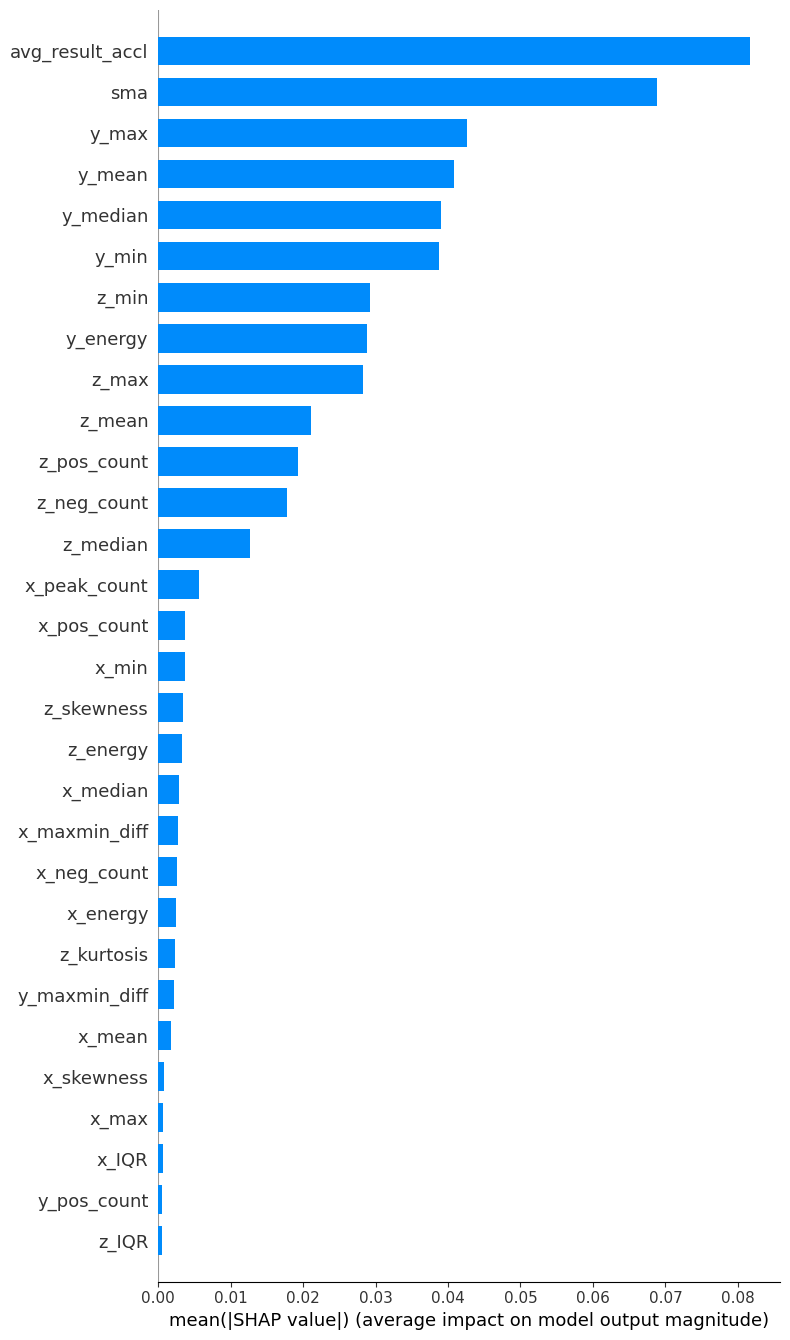

In [79]:
# Chuyển test set thành DataFrame có tên cột
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=features_train.columns)

# Vẽ bar chart (top 30 feature quan trọng nhất)
shap.summary_plot(shap_values, X_test_scaled_df, plot_type="bar", max_display=30)


In [82]:
import joblib
import os
def get_model_size_kb(model, scaler, name):
    """Lưu model & (nếu có) scaler, tính dung lượng và số tham số"""
    model_path = f"{name}_model.pkl"
    joblib.dump(model, model_path)
    model_kb = os.path.getsize(model_path) / 1024

    total_kb = model_kb
    scaler_kb = 0

    # 🔹 Lưu scaler nếu có
    if scaler is not None:
        scaler_path = f"{name}_scaler.pkl"
        joblib.dump(scaler, scaler_path)
        scaler_kb = os.path.getsize(scaler_path) / 1024
        total_kb += scaler_kb

    # 🔹 In kích thước
    print(f"📦 {name}: Model = {model_kb:.2f} KB | Scaler = {scaler_kb:.2f} KB | Total = {total_kb:.2f} KB")

    # 🔹 Nếu là mô hình tuyến tính (LR, SVM)
    if hasattr(model, "coef_"):
        n_params = np.prod(model.coef_.shape) + len(model.intercept_)
        print(f"🔢  → Số tham số huấn luyện: {n_params}")

    # 🔹 Nếu là mô hình cây (RF, GB)
    elif hasattr(model, "estimators_"):
        try:
            n_nodes = 0
            for est in model.estimators_:
                # GradientBoosting có thể là mảng 2D các cây con
                if isinstance(est, (list, np.ndarray)):
                    for sub_est in est:
                        if hasattr(sub_est, "tree_"):
                            n_nodes += sub_est.tree_.node_count
                else:
                    if hasattr(est, "tree_"):
                        n_nodes += est.tree_.node_count
            print(f"🌲  → Tổng số nút trong mô hình cây: {n_nodes}")
        except Exception as e:
            print(f"⚠️  Không thể đếm số nút (lý do: {e})")

    print("-" * 70)
    return total_kb

get_model_size_kb(modelRF, None, "RandomForest")
get_model_size_kb(modelLR, scalerLr, "LogisticRegression")
get_model_size_kb(modelSVM, scalerSVM, "SVM")

📦 RandomForest: Model = 58.42 KB | Scaler = 0.00 KB | Total = 58.42 KB
🌲  → Tổng số nút trong mô hình cây: 620
----------------------------------------------------------------------
📦 LogisticRegression: Model = 1.23 KB | Scaler = 2.57 KB | Total = 3.80 KB
🔢  → Số tham số huấn luyện: 51
----------------------------------------------------------------------
📦 SVM: Model = 12.29 KB | Scaler = 2.57 KB | Total = 14.86 KB
🔢  → Số tham số huấn luyện: 51
----------------------------------------------------------------------


14.861328125